## TP6

Integrantes:
* Martín Fosco LU: 449/13
* Javier Minces LU: 231/13

In [145]:
import nltk
import xml.etree.ElementTree
from scipy import stats
import numpy as np

### 1 - 1
Preprocesamiento: agregamos tags "root" y "/root" para poder leerlo como un solo árbol. Reemplazamos los & por "ampersand" para evitar errores

In [26]:
e = xml.etree.ElementTree.parse('ap/ap.txt').getroot()
d = dict()
for doc in e:
    d[doc[0].text] = doc[1].text



 Record-breaking heat scorched both coasts Sunday, wilting several major league pitchers and sending residents in the normally cool San Francisco Bay area streaming to the beaches. The mercury soared to a record 103 degrees in downtown San Francisco. It was the city's highest temperature since record keeping began 125 years ago, exceeding the previous mark of 102 degrees set on Oct. 5, 1987. On the East Coast, Philadelphia hit a record high for the date of 102 degrees, which was also a record fifth day in a row of triple-digit highs. Downtown Baltimore set a record high for the date of 103 degrees. In California, the heat heightened the danger of fire and and led officials to close Mount Diablo State Park in Contra Costa County, east of San Francisco, and parts of Mount Tamalpais, northwest of the city, officials said. By noon, the parking lot at Marin County's Stinson Beach was jammed, and motorists inched along several miles of roads leading to the area. National Weather Service for

### 1 - 2
Para calcular el tamaño del vocabulario:
* Eliminamos stop words (palabra comunes que no aportan información)
* Eliminamos todo lo que no sea alfabético
* Lematizamos (convertimos cada palabra a su forma basica, ej: plurales, conjugaciones de verbos)

In [102]:
'''
vocab = dict()
for text in d.values():
    words = text.strip().lower().split()
    for w in words:
        filt = filter(str.isalnum, w)
        if len(filt) == 0: continue
        if filt in vocab:
            vocab[filt] += 1
        else:
            vocab[filt] = 1
        
print len(vocab)'''

from nltk.stem import WordNetLemmatizer

vocab = []
lemmatizer = WordNetLemmatizer()
stop = set(nltk.corpus.stopwords.words("english"))

for text in d.values():
    tokens = nltk.word_tokenize(text.lower())
    filtered = [t for t in tokens if t not in stop and t.isalpha()]
    lem = [lemmatizer.lemmatize(t) for t in filtered]
    vocab += lem
print len(set(vocab))
    

29234


### 1 - 3
De las palabras obtenidas en el punto anterior nos fijamos cuantas veces aparece la nº 500 por orden de frecuencia. Con las palabras que aparecen una cantidad de veces mayor o igual calculamos los par más asociados. La metrica usada es la información mutua.



In [209]:
from nltk.collocations import *

fd = nltk.FreqDist(vocab)
words = fd.most_common(500)
threshold = min([word[1] for word in words])
print threshold

finder = BigramCollocationFinder.from_words(vocab, window_size = 3)
finder.apply_freq_filter(threshold)
bigram_measures = nltk.collocations.BigramAssocMeasures()
#"Scores ngrams by pointwise mutual information"
finder.nbest(bigram_measures.pmi, 9) 

180


[('white', 'house'),
 ('vice', 'president'),
 ('new', 'york'),
 ('soviet', 'union'),
 ('united', u'state'),
 (u'year', 'ago'),
 ('last', 'week'),
 ('last', 'year'),
 ('president', 'bush')]

In [51]:
'''limit = sorted(vocab.values())[-500]
topn = []
for word in vocab:
    if vocab[word] >= limit:
        topn.append(word)'''


        


500


### 2 - 1
Preprocesamiento: eliminamos todo lo que está entre el marcador de inicio y fin del libro.

Tokenizamos, filtramos no alfabéticos, lematizamos (aunque en el paper no lo hicieron). No eliminamos stop words porque 'for' es una de ellas

In [269]:
'''book = open("Origin.txt")
processed = []
for line in book:
    words = line.strip().lower().split()
    for w in words:
        filt = filter(str.isalnum, w)
        if len(filt) == 0: continue
        processed.append(filt)

print processed'''

filename=open("Origin.txt","r")
tokens = []
for line in filename.readlines():
    tokenize = nltk.word_tokenize(line.lower())
    filtered = [t for t in tokenize if t.isalpha()]
    lem = [lemmatizer.lemmatize(t) for t in filtered]
    tokens += lem
    
print tokens

['produced', 'by', 'sue', 'asscher', 'the', 'origin', 'of', u'specie', 'by', u'mean', 'of', 'natural', 'selection', 'or', 'the', 'preservation', 'of', 'favoured', u'race', 'in', 'the', 'struggle', 'for', 'life', 'by', 'charles', 'darwin', 'author', 'of', 'the', 'descent', 'of', 'man', 'etc', 'sixth', 'london', 'edition', 'with', 'all', u'addition', 'and', u'correction', 'the', 'edition', 'is', 'often', 'considered', 'the', 'definitive', 'edition', 'also', 'see', 'project', 'gutenberg', 'etext', 'for', 'the', 'first', 'edition', 'but', 'with', 'regard', 'to', 'the', 'material', 'world', 'we', 'can', 'at', 'least', 'go', 'so', 'far', u'a', 'this', 'we', 'can', 'perceive', 'that', u'event', 'are', 'brought', 'about', 'not', 'by', 'insulated', u'interposition', 'of', 'divine', 'power', 'exerted', 'in', 'each', 'particular', 'case', 'but', 'by', 'the', 'establishment', 'of', 'general', u'law', 'whewell', 'bridgewater', 'treatise', 'the', 'only', 'distinct', 'meaning', 'of', 'the', 'word', '

### 2 - 2: Autocorrelación
Paper: https://arxiv.org/pdf/0907.1558.pdf

La idea es calcular la auocorrelación de la densidad de distintas palabras a lo largo del texto. La idea es tener una serie binaria según si la palabra en la posición n es o no lo que buscás. Después, para calcular la densidad en la posición n, multiplicamos todo el vector por una gaussiana de sigma 50 (y rango 3 sigma) y sumamos.

565


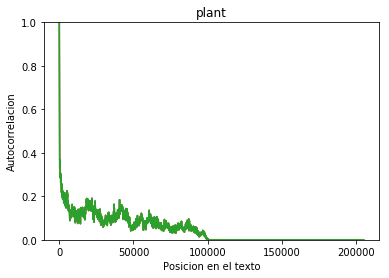

179


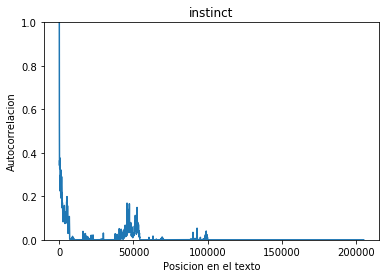

1466


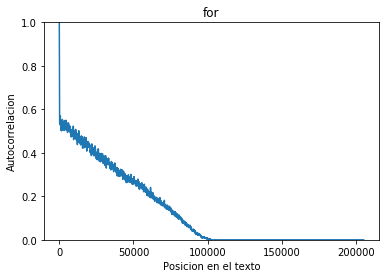

In [207]:
from matplotlib import pyplot as plt

words = ["plant", "instinct", "for"]
sigma = 50
for word in words:
    norm = []
    suma = []
    dirac = [word == token for token in tokens]
    print sum(dirac)
    for j in range(len(dirac)):
        prod = []
        start = max(0, j - 3*sigma)
        # Calcular todos los valores de la normal es muy lento
        # Así que aprovecho que la dirac es esparsa para calcular solo los que necesito
        for x in range(start, min(len(dirac) - 1, j+3*sigma)):
            if (x + start >= len(dirac)): break
            norm = 0
            if dirac[x + start]:
                norm = stats.norm.pdf(x, loc = j, scale = 50)
            prod.append(norm)
        suma.append(sum(prod))
    # Esto me da la autocorrelación desde distancia negativa máxima a positiva máxima
    y = np.correlate(suma, suma, "full")
    # Me quedo con las positivas
    y = y[len(y)/2:]
    # Normalizo
    y = [yi/y[0] for yi in y]
    plt.plot(range(len(y)), y)
    plt.ylim(0, 1)
    plt.title(word)
    plt.xlabel("Posicion en el texto")
    plt.ylabel("Autocorrelacion")
    plt.show()
        
    

In [ ]:
Similitud entre dos vectores de palabras: distancia coseno

In [277]:
### Para obtener palabras con diferentes frecuencias, filtro los repetidos en la lista de frecuencias, 
# y tomo 100 equidistiantes entre sí
fd = nltk.FreqDist(tokens)
tuplas = fd.most_common()
sinrepes = []
for i in range(len(tuplas) - 1):
    if tuplas[i][1] > tuplas[i + 1][1]:
        sinrepes.append(tuplas[i][0])
sample = [sinrepes[i] for i in range(1, len(sinrepes), int(len(sinrepes)/100.0))]
sample = sample[:100]

words = sample
p = 3000.0
division = len(tokens) / float(p)
partitions = [tokens[int(round(p * i)) : int(round(p * (i + 1)))] for i in range(int(division) - 1)]

### Para cada palabra, calculo la entropía para la partición
def getEntropy(word, partition):
    probs = []
    for partition in partitions:
        occ = sum([word == w for word in partition])
        prob = occ / float(len(partition))
        if (prob == 0):
            probs.append(0)
        else:
            probs.append(-prob * np.log2(prob))
    return sum(probs)

y1 = []

for w in words:
    y1.append(getEntropy(w, partitions))

### 2 - 4
Reuso el método anterior para calcular la entropía, pero shuffleo el texto antes de hacer las particiones


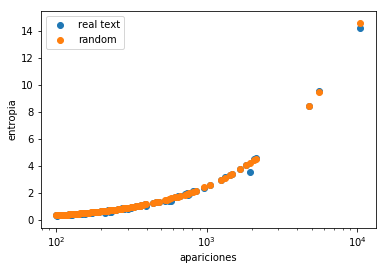

In [288]:
shuffled = tokens[:]
np.random.shuffle(shuffled)

y2 = []
x = []

partitions = [shuffled[int(round(p * i)) : int(round(p * (i + 1)))] for i in range(int(division) - 1)]
for w in words:
    y2.append(getEntropy(w, partitions))
    x.append(fd[w])
    
plt.scatter(x, y1, label = "real text")
plt.scatter(x, y2, label = "random")
plt.xscale('log')
plt.legend()
plt.xlabel("apariciones")
plt.ylabel("entropia")
plt.show()


No v